# 3rd Level Model Structure: Everything (Linking Stages)

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from pyomo import environ as pe
from modules.global_set import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify2
from utility.model_utility import add_dual, update_dual, check_DOF

model = pe.ConcreteModel()

# Global Set

In [3]:
model.TRAY = pe.RangeSet(1,1)

# Construct Reactive Stages

In [4]:
model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[1].T_F
| reactive[1].P
| reactive[1].cat
| reactive[1].Q_main
| reactive[1].x_
| reactive[1].y_
| reactive[1].x
| reactive[1].y
| reactive[1].z
| reactive[1].L
| reactive[1].V
| reactive[1].F
| reactive[1].H_L_
| reactive[1].H_V_
| reactive[1].H_L
| reactive[1].H_V
| reactive[1].T
| reactive[1].H_F
| reactive[1].f_V
| reactive[1].f_L
| reactive[1].r_total_comp
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[1].kinetics_block.k_FT
| reactive[1].kinetics_block.r_FT_total
| reactive[1].kinetics_block.g0_FT
| reactive[1].kinetics_block.alpha
| reactive[1].kinetics_block.r_FT_cnum
| reactive[1].kinetics_block.r_FT_comp
| reactive[1].kinetics_block.k_WGS
| reactive[1].kinetics_block.Ke_WGS
| reactive[1].kinetics_block.r_WGS
| reactive[1].kinetics_bloc

# Construct a single condenser

In [5]:
model.condenser = pe.Block(rule=condenser_stage_rule)

| Importing Condenser Stage......
| Adding the following local variable:
------------------------------------
| condenser.T
| condenser.T_F
| condenser.P
| condenser.Q_main
| condenser.x_
| condenser.y_
| condenser.x
| condenser.y
| condenser.z
| condenser.L
| condenser.W
| condenser.V
| condenser.F
| condenser.H_L_
| condenser.H_V_
| condenser.H_L
| condenser.H_V
| condenser.H_F
| condenser.f_V
| condenser.f_L
------------------------------------

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.energy_block.dH_F
| condenser.energy_block.dH_V
| condenser.energy_block.dH_L
| condenser.energy_block.dH_vap
--------------------------------------------------

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.VLE_block.n_ave
| condenser.VLE_block.n_ave_cal
| condenser.VLE_block.Hen
| condenser.VLE_block.Hen0
| condenser.VLE_blo

# Linking Stage Variables

### Vapor Between Reactive Stages

In [6]:
def V_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].V['in'] == model.reactive[j+1].V['out']
model.V_between_con = pe.Constraint(model.TRAY,rule=V_between_rule)

def Vy_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].y_['in',i] == model.reactive[j+1].y[i]
model.Vy_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Vy_between_rule)

def Vh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].H_V_['in'] == model.reactive[j+1].H_V
model.Vh_between_con = pe.Constraint(model.TRAY,rule=Vh_between_rule)

### Liquid Between Reactive Stages

In [7]:
def L_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].L['in'] == model.reactive[j].L['out']
model.L_between_con = pe.Constraint(model.TRAY,rule=L_between_rule)

def Lx_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].x_['in',i] == model.reactive[j].x[i]
model.Ly_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_between_rule)

def Lh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].H_L_['in'] == model.reactive[j].H_L
model.Lh_between_con = pe.Constraint(model.TRAY,rule=Lh_between_rule)

### Condenser

In [8]:
def V_condenser_rule(model):
    return model.reactive[model.TRAY.first()].V['out'] == model.condenser.V['in']
model.V_condenser_con = pe.Constraint(rule=V_condenser_rule)

def Vy_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].y[i] == model.condenser.y_['in',i]
model.Vy_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_condenser_rule)

def Vh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_V == model.condenser.H_V_['in']
model.Vh_condenser_con = pe.Constraint(rule=Vh_condenser_rule)

In [9]:
def L_condenser_rule(model):
    return model.reactive[model.TRAY.first()].L['in'] == model.condenser.L['out']
model.L_condenser_con = pe.Constraint(rule=L_condenser_rule)

def Lx_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].x_['in',i] == model.condenser.x[i]
model.Lx_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_condenser_rule)

def Lh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_L_['in'] == model.condenser.H_L
model.Lh_condenser_con = pe.Constraint(rule=Lh_condenser_rule)

# Fixing Redundent Stream Variables

In [10]:
# condenser
model.condenser.VLE_block.n_ave.fix(58)

model.condenser.F.fix(0)
model.condenser.T_F.fix(300+273.15)
model.condenser.z.fix(0)

model.condenser.V['P'].fix(0)
model.condenser.L['in'].fix(0)
for i in m.COMP_TOTAL: model.condenser.x_['in',i].fix(0)
model.condenser.H_L_['in'].fix(0)

In [11]:
# 'reboiler' fixing last stage V_in

model.reactive[model.TRAY.last()].V['in'].fix(0)
for i in m.COMP_TOTAL: model.reactive[model.TRAY.last()].y_['in',i].fix(0)
model.reactive[model.TRAY.last()].H_V_['in'].fix(0)

In [12]:
check_DOF(pe,model)

Active Equality Constraints:	 1980
Active Inequality Constraints:	 0
Active Variables:		 2163
Fixed Variables:		 169
DOF:				 14


# Load Operating Parameters

In [13]:
# condenser
model.condenser.P.fix(19)
#model.condenser.T.fix(30+273.15)
model.condenser.T.setub(30+273.15)
model.condenser.L['out'].setub(10)

# reactive stage
for j in model.reactive:
    model.reactive[j].cat.fix(2000)
    model.reactive[j].P.fix(20)
    model.reactive[j].VLE_block.n_ave.fix(58)
    
    model.reactive[j].F.fix(2)
    model.reactive[j].T_F.fix(200+273.15)
    model.reactive[j].z['CO'].fix(0.4)
    model.reactive[j].z['H2'].fix(0.6)
    model.reactive[j].z['C30H62'].fix(0)
    model.reactive[j].V['P'].fix(0)
    model.reactive[j].L['P'].fix(0)
    model.reactive[j].Q_main.fix(0)
    model.reactive[j].T.setlb(270+273.15)

In [14]:
check_DOF(pe,model)

Active Equality Constraints:	 1980
Active Inequality Constraints:	 0
Active Variables:		 2163
Fixed Variables:		 181
DOF:				 2


In [15]:
model.obj = pe.Objective(expr = model.reactive[1].L['out'] ,sense=pe.maximize)

In [16]:
opt = pe.SolverFactory('ipopt')
opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'
# opt.options['nlp_scaling_method'] = None
# opt.options['constr_viol_tol'] = 1e-7
# opt.options['acceptable_constr_viol_tol'] = 1e-7
opt.options['max_iter'] = 7000
# opt.options['dual_inf_tol'] = '+inf'
# opt.options['acceptable_dual_inf_tol'] = '+inf'

In [17]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [18]:
# with open('../saved_solutions/1_stage_condenser.pickle', 'rb') as f:
#         results = pickle.load(f)

In [19]:
# opt.options['warm_start_init_point'] = 'yes'
# opt.options['warm_start_bound_push'] = 1e-20
# opt.options['warm_start_mult_bound_push'] = 1e-20
# opt.options['mu_init'] = 1e-6

In [20]:
# model.solutions.load_from(results)

In [21]:
# model.ipopt_zL_in.update(model.ipopt_zL_out)
# model.ipopt_zU_in.update(model.ipopt_zU_out)

In [22]:
results = opt.solve(model,tee=True)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
max_iter=7000


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:     6625
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.....

  76r-4.0852552e+00 1.60e+02 9.99e+02   1.2 0.00e+00    -  0.00e+00 3.84e-07R  4
  77r-4.0856318e+00 1.60e+02 1.23e+03   1.2 1.87e+03    -  2.00e-03 1.46e-06f  1
  78r-4.2096436e+00 1.53e+02 1.48e+03  -0.9 7.57e+02    -  3.35e-03 1.40e-03f  1
  79r-4.3184971e+00 1.44e+02 1.40e+03  -0.9 2.62e+03    -  5.24e-04 1.27e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r-4.3669242e+00 1.33e+02 1.57e+03  -0.9 2.60e+03    -  3.20e-03 1.61e-03f  1
  81r-4.3669242e+00 1.33e+02 9.99e+02   1.2 0.00e+00    -  0.00e+00 4.93e-08R  2
  82r-4.3669244e+00 1.33e+02 1.29e+03   1.2 1.30e+03    -  1.79e-03 7.11e-10f  2
  83r-4.4169524e+00 1.25e+02 1.41e+03  -0.2 5.01e+02    -  2.78e-03 1.71e-03f  1
  84r-4.4049316e+00 1.06e+02 1.85e+03  -0.2 2.29e+03    -  7.06e-03 3.01e-03f  1
  85 -4.4050215e+00 1.06e+02 4.17e+00  -1.0 5.30e+04    -  1.22e-05 1.65e-06f  2
  86 -4.4050633e+00 1.06e+02 6.53e+01  -1.0 5.14e+04    -  2.37e-05 8.64e-07f  2
  87r-4.4050633e+00 1.06e+02

 169 -3.9322279e-02 1.45e+01 9.16e+04  -1.0 8.12e+01    -  8.94e-01 9.90e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -3.9321289e-04 2.19e+00 1.26e+06  -1.0 2.99e+01    -  1.93e-01 8.45e-01w  1
 171 -3.9222289e-06 1.17e+00 4.35e+05  -1.0 8.62e+01    -  6.39e-01 4.42e-01w  1
 172 -9.6364885e-06 2.39e-01 4.30e+05  -1.0 1.05e+02    -  9.37e-01 9.15e-01h  1
 173 -9.9269475e-06 1.01e+00 4.29e+05  -1.0 3.68e+03    -  7.94e-04 1.44e-03f  4
 174 -9.7770939e-06 2.55e+00 4.04e+05  -1.0 1.41e+02    -  4.60e-02 5.80e-02f  4
 175 -9.5847050e-06 2.51e+00 5.24e+06  -1.0 1.42e+01   0.6 1.00e+00 1.63e-02h  1
 176 -8.5947050e-08 3.23e-01 4.04e+06  -1.0 1.54e+01   0.1 2.56e-01 8.10e-01h  1
 177  9.0405295e-09 2.45e-01 1.21e+07  -1.0 1.39e+01  -0.4 8.18e-01 2.54e-01h  1
 178  9.9904053e-09 2.43e-01 2.82e+08  -1.0 1.01e+01  -0.9 1.00e+00 5.86e-03h  1
 179  9.9319630e-09 2.96e-01 1.12e+09  -1.0 1.51e+02    -  1.07e-02 4.69e-02f  4
iter    objective    inf_pr 

 261  9.9690139e-09 1.16e-03 2.95e+10  -1.0 6.17e-04  12.0 2.08e-03 2.08e-03s 15
 262  9.9690847e-09 1.16e-03 2.95e+10  -1.0 2.99e-03  11.5 4.73e-04 4.73e-04s 15
 263  9.9693073e-09 1.16e-03 2.95e+10  -1.0 6.91e-04  11.9 1.48e-03 1.48e-03s 15
 264  9.9693383e-09 1.16e-03 2.94e+10  -1.0 4.11e-03  11.5 2.12e-04 2.12e-04s 15
 265  9.9698625e-09 1.25e-03 2.93e+10  -1.0 7.81e-04  11.9 3.55e-03 3.55e-03s 15
 266  9.9699498e-09 1.34e-03 2.93e+10  -1.0 6.45e-03  11.4 6.18e-04 6.18e-04s 15
 267  9.9701064e-09 1.46e-03 2.93e+10  -1.0 8.75e-04  11.8 1.10e-03 1.10e-03s 15
 268r 9.9701064e-09 1.46e-03 1.00e+03  -1.0 0.00e+00  11.4 0.00e+00 0.00e+00R  1
 269r-2.7935071e-08 1.46e-03 1.84e+04  -1.0 3.95e+01    -  7.35e-02 3.79e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r-1.2253462e-06 1.42e-03 1.71e+04  -1.0 3.93e+01    -  1.97e-02 1.10e-02f  1
 271r-3.9229879e-06 1.35e-03 1.60e+04  -1.0 3.90e+01    -  3.05e-02 2.42e-02f  1
 272 -3.7213123e-06 1.34e-03

 357 -5.3306900e-03 1.72e-04 3.49e+06  -1.0 5.54e+00    -  1.00e+00 1.53e-02h  7
 358 -5.2578546e-03 1.75e-04 3.54e+06  -1.0 5.14e+00    -  1.00e+00 1.53e-02h  7
 359 -5.2217299e-03 1.75e-04 3.61e+06  -1.0 4.89e+00    -  1.00e+00 7.65e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360 -5.1506909e-03 1.79e-04 3.66e+06  -1.0 5.30e+00    -  1.00e+00 1.53e-02h  7
 361 -5.0799490e-03 1.82e-04 3.70e+06  -1.0 4.90e+00    -  1.00e+00 1.53e-02h  7
 362 -5.0448665e-03 1.82e-04 3.78e+06  -1.0 4.66e+00    -  1.00e+00 7.65e-03h  8
 363 -4.9759298e-03 1.85e-04 3.82e+06  -1.0 5.10e+00    -  1.00e+00 1.53e-02h  7
 364 -5.8050608e-04 2.23e-02 7.83e+04  -1.0 4.68e+00    -  1.00e+00 9.80e-01w  1
 365 -5.7951608e-06 6.04e-02 8.28e+05  -1.0 3.41e+01    -  7.53e-01 4.48e-01w  1
 366 -4.8051608e-08 5.51e-02 1.52e+06  -1.0 4.72e+01    -  5.22e-01 2.24e-01w  1
 367 -4.9072513e-03 1.88e-04 3.86e+06  -1.0 2.55e+01    -  1.00e+00 1.53e-02h  6
 368 -4.8731890e-03 1.88e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450 -2.5001381e-03 1.66e-04 4.88e+06  -1.0 1.56e+00    -  1.00e+00 7.70e-03h  8
 451 -2.4814113e-03 1.65e-04 4.87e+06  -1.0 1.56e+00    -  1.00e+00 7.71e-03h  8
 452 -2.4628189e-03 1.64e-04 4.86e+06  -1.0 1.56e+00    -  1.00e+00 7.71e-03h  8
 453 -2.4443559e-03 1.63e-04 4.86e+06  -1.0 1.54e+00    -  1.00e+00 7.71e-03h  8
 454 -2.4260186e-03 1.62e-04 4.85e+06  -1.0 1.52e+00    -  1.00e+00 7.71e-03h  8
 455 -9.4558740e-05 1.96e-02 6.58e+04  -1.0 1.50e+00    -  1.00e+00 9.87e-01w  1
 456 -9.3568740e-07 1.30e-01 9.42e+05  -1.0 2.46e+01    -  7.31e-01 4.21e-01w  1
 457  5.4312603e-10 1.09e-01 1.98e+06  -1.0 4.03e+01    -  4.64e-01 1.68e-01w  1
 458 -2.4078040e-03 1.61e-04 4.84e+06  -1.0 3.30e+01    -  1.00e+00 7.71e-03h  7
 459 -2.3897102e-03 1.60e-04 4.83e+06  -1.0 1.47e+00    -  1.00e+00 7.71e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460 -2.3717352e-03 1.59e-04

 542 -1.0663798e-03 9.11e-05 5.14e+06  -1.0 9.46e-01    -  1.00e+00 1.51e-02h  7
 543 -1.0498841e-03 9.23e-05 5.11e+06  -1.0 9.21e-01    -  1.00e+00 1.51e-02h  7
 544 -1.0336435e-03 9.36e-05 5.07e+06  -1.0 8.96e-01    -  1.00e+00 1.51e-02h  7
 545 -1.0176542e-03 9.50e-05 5.03e+06  -1.0 8.71e-01    -  1.00e+00 1.51e-02h  7
 546 -1.0166642e-05 1.31e-02 1.73e+05  -1.0 8.57e-01    -  1.00e+00 9.66e-01w  1
 547 -9.1766422e-08 1.23e-02 6.20e+05  -1.0 1.73e+01    -  5.46e-01 3.51e-01w  1
 548  8.9823358e-09 1.09e-02 2.35e+06  -1.0 2.05e+01    -  8.31e-01 1.17e-01w  1
 549 -1.0019122e-03 9.64e-05 4.98e+06  -1.0 4.51e+01    -  1.00e+00 1.51e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550 -9.8641374e-04 9.79e-05 4.94e+06  -1.0 8.66e-01    -  1.00e+00 1.51e-02h  7
 551 -9.7115500e-04 9.94e-05 4.89e+06  -1.0 8.93e-01    -  1.00e+00 1.51e-02h  7
 552 -9.5613229e-04 1.01e-04 4.85e+06  -1.0 9.22e-01    -  1.00e+00 1.51e-02h  7
 553 -9.4134196e-04 1.03e-04

 636 -1.8388004e-08 1.27e-04 5.34e+07  -1.0 2.52e+01    -  1.00e+00 9.77e-04h 11
 637 -1.8361926e-08 1.27e-04 5.36e+07  -1.0 2.52e+01    -  1.00e+00 9.77e-04h 11
 638 -1.8335873e-08 1.27e-04 5.37e+07  -1.0 2.52e+01    -  1.00e+00 9.77e-04h 11
 639 -1.8309846e-08 1.27e-04 5.38e+07  -1.0 2.51e+01    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640 -1.8283844e-08 1.27e-04 5.40e+07  -1.0 2.51e+01    -  1.00e+00 9.77e-04h 11
 641 -1.8257866e-08 1.27e-04 5.41e+07  -1.0 2.51e+01    -  1.00e+00 9.77e-04h 11
 642 -1.8231914e-08 1.27e-04 5.42e+07  -1.0 2.51e+01    -  1.00e+00 9.77e-04h 11
 643  8.3177360e-09 7.86e-02 6.25e+07  -1.0 2.51e+01    -  1.00e+00 1.00e+00w  1
 644  7.4242565e-09 6.22e-03 2.72e+07  -1.0 8.56e+00    -  9.93e-01 9.82e-01w  1
 645  5.9761685e-09 3.30e-03 1.37e+07  -1.0 9.89e-04   6.3 4.98e-01 4.69e-01w  1
 646 -1.8205987e-08 1.26e-04 5.43e+07  -1.0 2.16e-03   6.8 1.00e+00 9.77e-04h 10
 647 -1.8180084e-08 1.26e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730 -1.6549577e-08 1.19e-04 5.31e+07  -1.0 2.42e+01    -  1.00e+00 9.77e-04h 11
 731 -1.6525302e-08 1.19e-04 5.30e+07  -1.0 2.41e+01    -  1.00e+00 9.77e-04h 11
 732 -1.6501051e-08 1.19e-04 5.29e+07  -1.0 2.41e+01    -  1.00e+00 9.77e-04h 11
 733 -1.6476824e-08 1.18e-04 5.29e+07  -1.0 2.41e+01    -  1.00e+00 9.77e-04h 11
 734  8.3065691e-09 7.16e-02 6.37e+07  -1.0 2.41e+01    -  1.00e+00 1.00e+00w  1
 735  8.1040522e-09 6.11e-02 5.40e+07  -1.0 9.17e-03   8.2 1.51e-01 1.46e-01w  1
 736  7.1926063e-09 2.50e-02 5.48e+07  -1.0 1.36e-02   7.7 1.77e-03 5.92e-01w  1
 737 -1.6452622e-08 1.18e-04 5.28e+07  -1.0 8.01e-03   9.0 1.00e+00 9.77e-04h 10
 738 -1.6428443e-08 1.18e-04 5.28e+07  -1.0 2.41e+01    -  1.00e+00 9.77e-04h 11
 739 -1.6404289e-08 1.18e-04 5.27e+07  -1.0 2.41e+01    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740 -1.6380159e-08 1.18e-04

 822 -1.4884873e-08 1.11e-04 4.84e+07  -1.0 2.32e+01    -  1.00e+00 9.77e-04h 11
 823 -1.4862259e-08 1.11e-04 4.83e+07  -1.0 2.32e+01    -  1.00e+00 9.77e-04h 11
 824 -1.4839668e-08 1.11e-04 4.83e+07  -1.0 2.32e+01    -  1.00e+00 9.77e-04h 11
 825  8.2706600e-09 6.52e-02 6.05e+07  -1.0 2.31e+01    -  1.00e+00 1.00e+00w  1
 826  8.0538473e-09 5.51e-02 5.08e+07  -1.0 2.52e-03   9.0 1.60e-01 1.55e-01w  1
 827  7.3081848e-09 2.88e-02 5.08e+07  -1.0 5.89e-03   8.5 1.94e-03 4.77e-01w  1
 828 -1.4817099e-08 1.11e-04 4.82e+07  -1.0 7.99e-03   8.9 1.00e+00 9.77e-04h 10
 829 -1.4794553e-08 1.11e-04 4.81e+07  -1.0 2.31e+01    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830 -1.4772029e-08 1.10e-04 4.81e+07  -1.0 2.31e+01    -  1.00e+00 9.77e-04h 11
 831 -1.4749528e-08 1.10e-04 4.80e+07  -1.0 2.31e+01    -  1.00e+00 9.77e-04h 11
 832 -1.4727050e-08 1.10e-04 4.79e+07  -1.0 2.31e+01    -  1.00e+00 9.77e-04h 11
 833 -1.4704593e-08 1.10e-04

 917  8.0100982e-09 4.97e-02 4.81e+07  -1.0 8.19e-03   8.0 1.68e-01 1.63e-01w  1
 918  6.9487259e-09 1.63e-02 4.98e+07  -1.0 1.14e-02   7.6 1.94e-03 6.71e-01w  1
 919 -1.3291937e-08 1.03e-04 4.40e+07  -1.0 1.49e-02   8.9 1.00e+00 9.77e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920 -1.3270910e-08 1.03e-04 4.39e+07  -1.0 2.22e+01    -  1.00e+00 9.77e-04h 11
 921 -1.3249904e-08 1.03e-04 4.39e+07  -1.0 2.22e+01    -  1.00e+00 9.77e-04h 11
 922 -1.3228919e-08 1.03e-04 4.38e+07  -1.0 2.22e+01    -  1.00e+00 9.77e-04h 11
 923 -1.3207955e-08 1.03e-04 4.37e+07  -1.0 2.22e+01    -  1.00e+00 9.77e-04h 11
 924 -1.3187012e-08 1.03e-04 4.37e+07  -1.0 2.21e+01    -  1.00e+00 9.77e-04h 11
 925 -1.3166089e-08 1.03e-04 4.36e+07  -1.0 2.21e+01    -  1.00e+00 9.77e-04h 11
 926 -1.3145188e-08 1.03e-04 4.36e+07  -1.0 2.21e+01    -  1.00e+00 9.77e-04h 11
 927 -1.3124307e-08 1.03e-04 4.35e+07  -1.0 2.21e+01    -  1.00e+00 9.77e-04h 11
 928 -1.3103446e-08 1.03e-04

1011 -1.1849736e-08 9.66e-05 4.03e+07  -1.0 2.13e+01    -  1.00e+00 9.77e-04h 11
1012 -1.1830140e-08 9.65e-05 4.02e+07  -1.0 2.13e+01    -  1.00e+00 9.77e-04h 11
1013 -1.1810563e-08 9.64e-05 4.02e+07  -1.0 2.12e+01    -  1.00e+00 9.77e-04h 11
1014 -1.1791005e-08 9.63e-05 4.01e+07  -1.0 2.12e+01    -  1.00e+00 9.77e-04h 11
1015 -1.1771467e-08 9.62e-05 4.01e+07  -1.0 2.12e+01    -  1.00e+00 9.77e-04h 11
1016 -1.1751948e-08 9.62e-05 4.00e+07  -1.0 2.12e+01    -  1.00e+00 9.77e-04h 11
1017 -1.1732448e-08 9.61e-05 4.00e+07  -1.0 2.12e+01    -  1.00e+00 9.77e-04h 11
1018 -1.1712968e-08 9.60e-05 3.99e+07  -1.0 2.12e+01    -  1.00e+00 9.77e-04h 11
1019 -1.1693507e-08 9.59e-05 3.99e+07  -1.0 2.12e+01    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020  8.2149684e-09 5.32e-02 5.54e+07  -1.0 2.12e+01    -  1.00e+00 1.00e+00w  1
1021  7.9727366e-09 4.41e-02 4.57e+07  -1.0 5.25e-03   8.3 1.76e-01 1.71e-01w  1
1022  7.0543630e-09 1.87e-02

1104 -1.0487139e-08 9.01e-05 3.71e+07  -1.0 2.04e+01    -  1.00e+00 9.77e-04h 11
1105 -1.0468886e-08 9.00e-05 3.70e+07  -1.0 2.03e+01    -  1.00e+00 9.77e-04h 11
1106 -1.0450652e-08 9.00e-05 3.70e+07  -1.0 2.03e+01    -  1.00e+00 9.77e-04h 11
1107 -1.0432436e-08 8.99e-05 3.69e+07  -1.0 2.03e+01    -  1.00e+00 9.77e-04h 11
1108 -1.0414238e-08 8.98e-05 3.69e+07  -1.0 2.03e+01    -  1.00e+00 9.77e-04h 11
1109 -1.0396057e-08 8.97e-05 3.69e+07  -1.0 2.03e+01    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110 -1.0377895e-08 8.96e-05 3.68e+07  -1.0 2.03e+01    -  1.00e+00 9.77e-04h 11
1111  8.2022283e-09 4.83e-02 5.41e+07  -1.0 2.03e+01    -  1.00e+00 1.00e+00w  1
1112  7.9532127e-09 3.98e-02 4.43e+07  -1.0 5.18e-03   8.2 1.80e-01 1.76e-01w  1
1113  6.9393648e-09 1.45e-02 4.55e+07  -1.0 8.07e-03   7.8 2.14e-03 6.36e-01w  1
1114 -1.0359750e-08 8.95e-05 3.68e+07  -1.0 3.87e-03   9.1 1.00e+00 9.77e-04h 10
1115 -1.0341623e-08 8.94e-05

1198 -9.2007469e-09 8.40e-05 3.43e+07  -1.0 1.94e+01    -  1.00e+00 9.77e-04h 11
1199 -9.1837562e-09 8.39e-05 3.43e+07  -1.0 1.94e+01    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200 -9.1667822e-09 8.38e-05 3.42e+07  -1.0 1.94e+01    -  1.00e+00 9.77e-04h 11
1201 -9.1498247e-09 8.37e-05 3.42e+07  -1.0 1.94e+01    -  1.00e+00 9.77e-04h 11
1202  8.1976409e-09 4.38e-02 5.33e+07  -1.0 1.94e+01    -  1.00e+00 1.00e+00w  1
1203  7.9449812e-09 3.60e-02 4.35e+07  -1.0 5.06e-03   8.1 1.84e-01 1.79e-01w  1
1204  6.8603877e-09 1.14e-02 4.52e+07  -1.0 7.51e-03   7.7 2.15e-03 6.83e-01w  1
1205 -9.1328838e-09 8.37e-05 3.42e+07  -1.0 5.41e-03   9.0 1.00e+00 9.77e-04h 10
1206 -9.1159595e-09 8.36e-05 3.41e+07  -1.0 1.94e+01    -  1.00e+00 9.77e-04h 11
1207 -9.0990517e-09 8.35e-05 3.41e+07  -1.0 1.94e+01    -  1.00e+00 9.77e-04h 11
1208 -9.0821604e-09 8.34e-05 3.41e+07  -1.0 1.94e+01    -  1.00e+00 9.77e-04h 11
1209 -9.0652856e-09 8.33e-05

1293  8.1924098e-09 3.88e-02 5.25e+07  -1.0 1.83e+01    -  1.00e+00 1.00e+00w  1
1294  7.9362946e-09 3.17e-02 4.27e+07  -1.0 4.78e-03   8.1 1.87e-01 1.83e-01w  1
1295  6.7364356e-09 7.60e-03 4.55e+07  -1.0 6.75e-03   7.6 2.14e-03 7.60e-01w  1
1296 -7.7050410e-09 7.68e-05 3.12e+07  -1.0 8.69e-03   8.9 1.00e+00 1.95e-03h  9
1297 -7.6739908e-09 7.67e-05 3.11e+07  -1.0 1.83e+01    -  1.00e+00 1.95e-03h 10
1298 -7.6430006e-09 7.65e-05 3.11e+07  -1.0 1.83e+01    -  1.00e+00 1.95e-03h 10
1299 -7.6120705e-09 7.64e-05 3.10e+07  -1.0 1.83e+01    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300 -7.5812002e-09 7.63e-05 3.10e+07  -1.0 1.82e+01    -  1.00e+00 1.95e-03h 10
1301 -7.5503896e-09 7.61e-05 3.09e+07  -1.0 1.82e+01    -  1.00e+00 1.95e-03h 10
1302 -7.5196386e-09 7.60e-05 3.09e+07  -1.0 1.82e+01    -  1.00e+00 1.95e-03h 10
1303 -7.4889471e-09 7.58e-05 3.08e+07  -1.0 1.82e+01    -  1.00e+00 1.95e-03h 10
1304 -7.4583149e-09 7.57e-05

1387 -5.6698968e-09 6.71e-05 2.80e+07  -1.0 6.03e-03   8.8 1.00e+00 1.95e-03h  9
1388 -5.6427584e-09 6.70e-05 2.80e+07  -1.0 1.67e+01    -  1.00e+00 1.95e-03h 10
1389 -5.6156717e-09 6.68e-05 2.80e+07  -1.0 1.67e+01    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390 -5.5886367e-09 6.67e-05 2.79e+07  -1.0 1.66e+01    -  1.00e+00 1.95e-03h 10
1391 -5.5616532e-09 6.66e-05 2.79e+07  -1.0 1.66e+01    -  1.00e+00 1.95e-03h 10
1392 -5.5347211e-09 6.65e-05 2.79e+07  -1.0 1.66e+01    -  1.00e+00 1.95e-03h 10
1393 -5.5078403e-09 6.63e-05 2.78e+07  -1.0 1.66e+01    -  1.00e+00 1.95e-03h 10
1394 -5.4810108e-09 6.62e-05 2.78e+07  -1.0 1.66e+01    -  1.00e+00 1.95e-03h 10
1395 -5.4542323e-09 6.61e-05 2.78e+07  -1.0 1.65e+01    -  1.00e+00 1.95e-03h 10
1396 -5.4275048e-09 6.59e-05 2.77e+07  -1.0 1.65e+01    -  1.00e+00 1.95e-03h 10
1397  8.2309129e-09 3.08e-02 5.33e+07  -1.0 1.65e+01    -  1.00e+00 1.00e+00w  1
1398  7.9837590e-09 2.52e-02

1481 -5.9417407e-08 6.11e-05 6.44e+04  -3.8 1.50e+01    -  1.00e+00 4.88e-04h 12
1482 -5.9384489e-08 6.10e-05 6.46e+04  -3.8 1.49e+01    -  1.00e+00 4.88e-04h 12
1483 -5.9351593e-08 6.10e-05 6.48e+04  -3.8 1.49e+01    -  1.00e+00 4.88e-04h 12
1484 -5.9318721e-08 6.10e-05 6.51e+04  -3.8 1.49e+01    -  1.00e+00 4.88e-04h 12
1485  7.9602099e-09 2.73e-02 9.16e+04  -3.8 1.49e+01    -  1.00e+00 1.00e+00w  1
1486  7.0824622e-09 1.55e-03 6.33e+04  -3.8 3.19e+00    -  1.00e+00 9.70e-01w  1
1487  6.3350378e-09 1.18e-03 4.81e+04  -3.8 1.93e-04   9.0 2.60e-01 2.39e-01w  1
1488 -5.9285870e-08 6.10e-05 6.53e+04  -3.8 3.18e-04   8.5 1.00e+00 4.88e-04h 11
1489 -5.9253040e-08 6.09e-05 6.54e+04  -3.8 1.49e+01    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490 -5.9220230e-08 6.09e-05 6.56e+04  -3.8 1.49e+01    -  1.00e+00 4.88e-04h 12
1491 -5.9187441e-08 6.09e-05 6.58e+04  -3.8 1.49e+01    -  1.00e+00 4.88e-04h 12
1492 -5.9154672e-08 6.08e-05

1577  7.0398331e-09 1.35e-03 6.14e+04  -3.8 3.06e+00    -  1.00e+00 9.74e-01w  1
1578  6.4005105e-09 1.02e-03 4.55e+04  -3.8 4.60e-04   4.1 2.59e-01 2.41e-01w  1
1579 -5.7029356e-08 5.90e-05 6.60e+04  -3.8 1.08e-03   4.6 1.00e+00 4.88e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1580 -5.6997691e-08 5.89e-05 6.59e+04  -3.8 1.46e+01    -  1.00e+00 4.88e-04h 12
1581 -5.6966042e-08 5.89e-05 6.59e+04  -3.8 1.45e+01    -  1.00e+00 4.88e-04h 12
1582 -5.6934409e-08 5.89e-05 6.58e+04  -3.8 1.45e+01    -  1.00e+00 4.88e-04h 12
1583 -5.6902791e-08 5.89e-05 6.58e+04  -3.8 1.45e+01    -  1.00e+00 4.88e-04h 12
1584 -5.6871189e-08 5.88e-05 6.58e+04  -3.8 1.45e+01    -  1.00e+00 4.88e-04h 12
1585 -5.6839603e-08 5.88e-05 6.57e+04  -3.8 1.45e+01    -  1.00e+00 4.88e-04h 12
1586 -5.6808032e-08 5.88e-05 6.57e+04  -3.8 1.45e+01    -  1.00e+00 4.88e-04h 12
1587 -5.6776477e-08 5.88e-05 6.56e+04  -3.8 1.45e+01    -  1.00e+00 4.88e-04h 12
1588 -5.6744938e-08 5.87e-05

1672 -5.4789032e-08 5.70e-05 6.30e+04  -3.8 1.42e+01    -  1.00e+00 4.88e-04h 12
1673 -5.4758474e-08 5.70e-05 6.30e+04  -3.8 1.42e+01    -  1.00e+00 4.88e-04h 12
1674 -5.4727931e-08 5.69e-05 6.29e+04  -3.8 1.42e+01    -  1.00e+00 4.88e-04h 12
1675 -5.4697403e-08 5.69e-05 6.29e+04  -3.8 1.42e+01    -  1.00e+00 4.88e-04h 12
1676 -5.4666890e-08 5.69e-05 6.28e+04  -3.8 1.42e+01    -  1.00e+00 4.88e-04h 12
1677 -5.4636392e-08 5.69e-05 6.28e+04  -3.8 1.41e+01    -  1.00e+00 4.88e-04h 12
1678 -5.4605909e-08 5.68e-05 6.28e+04  -3.8 1.41e+01    -  1.00e+00 4.88e-04h 12
1679 -5.4575442e-08 5.68e-05 6.27e+04  -3.8 1.41e+01    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680  7.7918325e-09 2.42e-02 8.92e+04  -3.8 1.41e+01    -  1.00e+00 1.00e+00w  1
1681  7.0045942e-09 1.27e-03 6.03e+04  -3.8 2.92e+00    -  1.00e+00 9.73e-01w  1
1682  6.4284370e-09 9.71e-04 4.48e+04  -3.8 4.98e-04   3.7 2.56e-01 2.38e-01w  1
1683 -5.4544989e-08 5.68e-05

1766 -5.2597453e-08 5.51e-05 6.01e+04  -3.8 1.38e+01    -  1.00e+00 4.88e-04h 12
1767 -5.2567977e-08 5.50e-05 6.00e+04  -3.8 1.38e+01    -  1.00e+00 4.88e-04h 12
1768 -5.2538514e-08 5.50e-05 6.00e+04  -3.8 1.38e+01    -  1.00e+00 4.88e-04h 12
1769 -5.2509066e-08 5.50e-05 6.00e+04  -3.8 1.38e+01    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1770 -5.2479633e-08 5.50e-05 5.99e+04  -3.8 1.38e+01    -  1.00e+00 4.88e-04h 12
1771  7.7699115e-09 2.29e-02 8.84e+04  -3.8 1.38e+01    -  1.00e+00 1.00e+00w  1
1772  6.9747040e-09 1.21e-03 5.93e+04  -3.8 2.81e+00    -  1.00e+00 9.72e-01w  1
1773  6.4648662e-09 9.35e-04 4.46e+04  -3.8 5.37e-04   3.4 2.47e-01 2.30e-01w  1
1774 -5.2450214e-08 5.49e-05 5.99e+04  -3.8 7.95e-04   4.7 1.00e+00 4.88e-04h 11
1775 -5.2420810e-08 5.49e-05 5.98e+04  -3.8 1.38e+01    -  1.00e+00 4.88e-04h 12
1776 -5.2391421e-08 5.49e-05 5.98e+04  -3.8 1.38e+01    -  1.00e+00 4.88e-04h 12
1777 -5.2362045e-08 5.49e-05

1861 -5.0454975e-08 5.32e-05 5.73e+04  -3.8 1.34e+01    -  1.00e+00 4.88e-04h 12
1862  7.7495928e-09 2.17e-02 8.76e+04  -3.8 1.34e+01    -  1.00e+00 1.00e+00w  1
1863  6.9461104e-09 1.16e-03 5.85e+04  -3.8 2.69e+00    -  1.00e+00 9.72e-01w  1
1864  6.3189870e-09 8.72e-04 4.28e+04  -3.8 5.79e-04   3.9 2.68e-01 2.47e-01w  1
1865 -5.0426555e-08 5.31e-05 5.72e+04  -3.8 2.24e-03   4.3 1.00e+00 4.88e-04h 11
1866 -5.0398149e-08 5.31e-05 5.72e+04  -3.8 1.34e+01    -  1.00e+00 4.88e-04h 12
1867 -5.0369757e-08 5.31e-05 5.72e+04  -3.8 1.34e+01    -  1.00e+00 4.88e-04h 12
1868 -5.0341379e-08 5.31e-05 5.71e+04  -3.8 1.34e+01    -  1.00e+00 4.88e-04h 12
1869 -5.0313014e-08 5.30e-05 5.71e+04  -3.8 1.34e+01    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1870 -5.0284664e-08 5.30e-05 5.71e+04  -3.8 1.34e+01    -  1.00e+00 4.88e-04h 12
1871 -5.0256328e-08 5.30e-05 5.70e+04  -3.8 1.34e+01    -  1.00e+00 4.88e-04h 12
1872 -5.0228006e-08 5.30e-05

1956 -4.8471567e-08 5.14e-05 5.47e+04  -3.8 2.13e-02   4.0 1.00e+00 4.88e-04h 11
1957 -4.8444124e-08 5.14e-05 5.47e+04  -3.8 1.31e+01    -  1.00e+00 4.88e-04h 12
1958 -4.8416695e-08 5.14e-05 5.47e+04  -3.8 1.31e+01    -  1.00e+00 4.88e-04h 12
1959 -4.8389280e-08 5.13e-05 5.46e+04  -3.8 1.30e+01    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960 -4.8361878e-08 5.13e-05 5.46e+04  -3.8 1.30e+01    -  1.00e+00 4.88e-04h 12
1961 -4.8334489e-08 5.13e-05 5.46e+04  -3.8 1.30e+01    -  1.00e+00 4.88e-04h 12
1962 -4.8307114e-08 5.13e-05 5.45e+04  -3.8 1.30e+01    -  1.00e+00 4.88e-04h 12
1963 -4.8279753e-08 5.12e-05 5.45e+04  -3.8 1.30e+01    -  1.00e+00 4.88e-04h 12
1964 -4.8252405e-08 5.12e-05 5.45e+04  -3.8 1.30e+01    -  1.00e+00 4.88e-04h 12
1965 -4.8225070e-08 5.12e-05 5.44e+04  -3.8 1.30e+01    -  1.00e+00 4.88e-04h 12
1966  7.7283679e-09 2.04e-02 8.69e+04  -3.8 1.30e+01    -  1.00e+00 1.00e+00w  1
1967  6.9151184e-09 1.10e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2050 -4.6503388e-08 4.97e-05 5.23e+04  -3.8 1.27e+01    -  1.00e+00 4.88e-04h 12
2051 -4.6476916e-08 4.96e-05 5.23e+04  -3.8 1.27e+01    -  1.00e+00 4.88e-04h 12
2052 -4.6450456e-08 4.96e-05 5.22e+04  -3.8 1.27e+01    -  1.00e+00 4.88e-04h 12
2053 -4.6424009e-08 4.96e-05 5.22e+04  -3.8 1.27e+01    -  1.00e+00 4.88e-04h 12
2054 -4.6397575e-08 4.96e-05 5.22e+04  -3.8 1.27e+01    -  1.00e+00 4.88e-04h 12
2055 -4.6371155e-08 4.95e-05 5.21e+04  -3.8 1.27e+01    -  1.00e+00 4.88e-04h 12
2056 -4.6344747e-08 4.95e-05 5.21e+04  -3.8 1.27e+01    -  1.00e+00 4.88e-04h 12
2057  7.7115992e-09 1.93e-02 8.64e+04  -3.8 1.27e+01    -  1.00e+00 1.00e+00w  1
2058  6.8895450e-09 1.05e-03 5.70e+04  -3.8 2.47e+00    -  1.00e+00 9.70e-01w  1
2059  6.2206979e-09 7.79e-04 4.10e+04  -3.8 6.83e-04   4.1 2.79e-01 2.56e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2060 -4.6318352e-08 4.95e-05

2144 -4.4604733e-08 4.80e-05 5.00e+04  -3.8 1.24e+01    -  1.00e+00 4.88e-04h 12
2145 -4.4579195e-08 4.79e-05 5.00e+04  -3.8 1.24e+01    -  1.00e+00 4.88e-04h 12
2146 -4.4553669e-08 4.79e-05 4.99e+04  -3.8 1.24e+01    -  1.00e+00 4.88e-04h 12
2147 -4.4528156e-08 4.79e-05 4.99e+04  -3.8 1.23e+01    -  1.00e+00 4.88e-04h 12
2148  7.6965638e-09 1.83e-02 8.61e+04  -3.8 1.23e+01    -  1.00e+00 1.00e+00w  1
2149  6.8654769e-09 9.99e-04 5.63e+04  -3.8 2.36e+00    -  1.00e+00 9.69e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2150  6.2753365e-09 7.51e-04 4.10e+04  -3.8 7.38e-04   3.7 2.71e-01 2.48e-01w  1
2151 -4.4502656e-08 4.79e-05 4.99e+04  -3.8 9.38e-03   4.1 1.00e+00 4.88e-04h 11
2152 -4.4477168e-08 4.79e-05 4.98e+04  -3.8 1.23e+01    -  1.00e+00 4.88e-04h 12
2153 -4.4451693e-08 4.78e-05 4.98e+04  -3.8 1.23e+01    -  1.00e+00 4.88e-04h 12
2154 -4.4426230e-08 4.78e-05 4.98e+04  -3.8 1.23e+01    -  1.00e+00 4.88e-04h 12
2155 -4.4400780e-08 4.78e-05

2237 -4.2797746e-08 4.64e-05 4.79e+04  -3.8 1.20e+01    -  1.00e+00 4.88e-04h 12
2238 -4.2773097e-08 4.63e-05 4.78e+04  -3.8 1.20e+01    -  1.00e+00 4.88e-04h 12
2239  7.6833057e-09 1.73e-02 8.59e+04  -3.8 1.20e+01    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2240  6.8429745e-09 9.53e-04 5.58e+04  -3.8 2.27e+00    -  1.00e+00 9.68e-01w  1
2241  6.1229362e-09 7.02e-04 3.96e+04  -3.8 7.98e-04   4.2 2.90e-01 2.63e-01w  1
2242 -4.2748460e-08 4.63e-05 4.78e+04  -3.8 9.70e-04   4.7 1.00e+00 4.88e-04h 11
2243 -4.2723836e-08 4.63e-05 4.78e+04  -3.8 1.20e+01    -  1.00e+00 4.88e-04h 12
2244 -4.2699223e-08 4.63e-05 4.77e+04  -3.8 1.20e+01    -  1.00e+00 4.88e-04h 12
2245 -4.2674622e-08 4.62e-05 4.77e+04  -3.8 1.20e+01    -  1.00e+00 4.88e-04h 12
2246 -4.2650034e-08 4.62e-05 4.77e+04  -3.8 1.20e+01    -  1.00e+00 4.88e-04h 12
2247 -4.2625458e-08 4.62e-05 4.77e+04  -3.8 1.20e+01    -  1.00e+00 4.88e-04h 12
2248 -4.2600893e-08 4.62e-05

2332  6.1848763e-09 6.76e-04 3.96e+04  -3.8 8.63e-04   3.9 2.83e-01 2.56e-01w  1
2333 -4.1053639e-08 4.48e-05 4.59e+04  -3.8 3.88e-03   4.3 1.00e+00 4.88e-04h 11
2334 -4.1029847e-08 4.48e-05 4.58e+04  -3.8 1.17e+01    -  1.00e+00 4.88e-04h 12
2335 -4.1006067e-08 4.48e-05 4.58e+04  -3.8 1.17e+01    -  1.00e+00 4.88e-04h 12
2336 -4.0982299e-08 4.47e-05 4.58e+04  -3.8 1.17e+01    -  1.00e+00 4.88e-04h 12
2337 -4.0958542e-08 4.47e-05 4.58e+04  -3.8 1.17e+01    -  1.00e+00 4.88e-04h 12
2338 -4.0934797e-08 4.47e-05 4.57e+04  -3.8 1.17e+01    -  1.00e+00 4.88e-04h 12
2339 -4.0911064e-08 4.47e-05 4.57e+04  -3.8 1.17e+01    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2340 -4.0887342e-08 4.46e-05 4.57e+04  -3.8 1.17e+01    -  1.00e+00 4.88e-04h 12
2341 -4.0863632e-08 4.46e-05 4.57e+04  -3.8 1.17e+01    -  1.00e+00 4.88e-04h 12
2342 -4.0839934e-08 4.46e-05 4.56e+04  -3.8 1.17e+01    -  1.00e+00 4.88e-04h 12
2343  7.6703812e-09 1.62e-02

2426 -3.9370169e-08 4.33e-05 4.40e+04  -3.8 1.14e+01    -  1.00e+00 4.88e-04h 12
2427 -3.9347204e-08 4.33e-05 4.40e+04  -3.8 1.14e+01    -  1.00e+00 4.88e-04h 12
2428 -3.9324251e-08 4.32e-05 4.39e+04  -3.8 1.14e+01    -  1.00e+00 4.88e-04h 12
2429 -3.9301308e-08 4.32e-05 4.39e+04  -3.8 1.14e+01    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2430 -3.9278377e-08 4.32e-05 4.39e+04  -3.8 1.14e+01    -  1.00e+00 4.88e-04h 12
2431 -3.9255458e-08 4.32e-05 4.39e+04  -3.8 1.14e+01    -  1.00e+00 4.88e-04h 12
2432 -3.9232549e-08 4.32e-05 4.38e+04  -3.8 1.14e+01    -  1.00e+00 4.88e-04h 12
2433 -3.9209652e-08 4.31e-05 4.38e+04  -3.8 1.14e+01    -  1.00e+00 4.88e-04h 12
2434  7.6610604e-09 1.53e-02 8.59e+04  -3.8 1.14e+01    -  1.00e+00 1.00e+00w  1
2435  6.8003007e-09 9.60e-04 5.49e+04  -3.8 2.07e+00    -  1.00e+00 9.67e-01w  1
2436  6.0418225e-09 7.02e-04 3.84e+04  -3.8 9.43e-04   4.4 3.00e-01 2.69e-01w  1
2437 -3.9186766e-08 4.31e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2520 -3.7723007e-08 4.18e-05 4.22e+04  -3.8 1.11e+01    -  1.00e+00 4.88e-04h 12
2521 -3.7700851e-08 4.18e-05 4.22e+04  -3.8 1.11e+01    -  1.00e+00 4.88e-04h 12
2522 -3.7678705e-08 4.18e-05 4.22e+04  -3.8 1.11e+01    -  1.00e+00 4.88e-04h 12
2523 -3.7656570e-08 4.18e-05 4.22e+04  -3.8 1.11e+01    -  1.00e+00 4.88e-04h 12
2524 -3.7634446e-08 4.17e-05 4.21e+04  -3.8 1.11e+01    -  1.00e+00 4.88e-04h 12
2525  7.6536259e-09 1.45e-02 8.60e+04  -3.8 1.11e+01    -  1.00e+00 1.00e+00w  1
2526  6.7830968e-09 1.04e-03 5.46e+04  -3.8 1.98e+00    -  1.00e+00 9.66e-01w  1
2527  6.1123488e-09 7.66e-04 3.86e+04  -3.8 1.02e-03   4.0 2.91e-01 2.62e-01w  1
2528 -3.7612332e-08 4.17e-05 4.21e+04  -3.8 2.56e-03   4.4 1.00e+00 4.88e-04h 11
2529 -3.7590230e-08 4.17e-05 4.21e+04  -3.8 1.10e+01    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2530 -3.7568138e-08 4.17e-05

2612 -3.6176566e-08 4.04e-05 4.06e+04  -3.8 1.08e+01    -  1.00e+00 4.88e-04h 12
2613 -3.6155167e-08 4.04e-05 4.06e+04  -3.8 1.08e+01    -  1.00e+00 4.88e-04h 12
2614 -3.6133779e-08 4.04e-05 4.06e+04  -3.8 1.08e+01    -  1.00e+00 4.88e-04h 12
2615 -3.6112401e-08 4.04e-05 4.05e+04  -3.8 1.08e+01    -  1.00e+00 4.88e-04h 12
2616  7.6481007e-09 1.37e-02 8.63e+04  -3.8 1.08e+01    -  1.00e+00 1.00e+00w  1
2617  6.7676914e-09 1.12e-03 5.43e+04  -3.8 1.90e+00    -  1.00e+00 9.65e-01w  1
2618  5.9633871e-09 8.15e-04 3.76e+04  -3.8 1.10e-03   4.6 3.08e-01 2.73e-01w  1
2619 -3.6091033e-08 4.03e-05 4.05e+04  -3.8 8.00e-04   5.0 1.00e+00 4.88e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2620 -3.6069676e-08 4.03e-05 4.05e+04  -3.8 1.08e+01    -  1.00e+00 4.88e-04h 12
2621 -3.6048330e-08 4.03e-05 4.05e+04  -3.8 1.08e+01    -  1.00e+00 4.88e-04h 12
2622 -3.6026994e-08 4.03e-05 4.05e+04  -3.8 1.07e+01    -  1.00e+00 4.88e-04h 12
2623 -3.6005668e-08 4.03e-05

2706 -3.4641666e-08 3.90e-05 3.91e+04  -3.8 1.05e+01    -  1.00e+00 4.88e-04h 12
2707  7.6445012e-09 1.30e-02 8.66e+04  -3.8 1.05e+01    -  1.00e+00 1.00e+00w  1
2708  6.7541332e-09 1.21e-03 5.42e+04  -3.8 1.81e+00    -  1.00e+00 9.65e-01w  1
2709  6.0382337e-09 8.88e-04 3.78e+04  -3.8 1.19e-03   4.2 3.01e-01 2.67e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2710 -3.4621018e-08 3.90e-05 3.91e+04  -3.8 1.43e-03   4.6 1.00e+00 4.88e-04h 11
2711 -3.4600381e-08 3.90e-05 3.90e+04  -3.8 1.05e+01    -  1.00e+00 4.88e-04h 12
2712 -3.4579753e-08 3.90e-05 3.90e+04  -3.8 1.05e+01    -  1.00e+00 4.88e-04h 12
2713 -3.4559136e-08 3.90e-05 3.90e+04  -3.8 1.05e+01    -  1.00e+00 4.88e-04h 12
2714 -3.4538529e-08 3.89e-05 3.90e+04  -3.8 1.05e+01    -  1.00e+00 4.88e-04h 12
2715 -3.4517932e-08 3.89e-05 3.90e+04  -3.8 1.05e+01    -  1.00e+00 4.88e-04h 12
2716 -3.4497345e-08 3.89e-05 3.89e+04  -3.8 1.04e+01    -  1.00e+00 4.88e-04h 12
2717 -3.4476768e-08 3.89e-05

2801 -3.3200498e-08 3.77e-05 3.77e+04  -3.8 1.00e-03   4.8 1.00e+00 4.88e-04h 11
2802 -3.3180555e-08 3.77e-05 3.77e+04  -3.8 1.02e+01    -  1.00e+00 4.88e-04h 12
2803 -3.3160622e-08 3.77e-05 3.76e+04  -3.8 1.02e+01    -  1.00e+00 4.88e-04h 12
2804 -3.3140698e-08 3.77e-05 3.76e+04  -3.8 1.02e+01    -  1.00e+00 4.88e-04h 12
2805 -3.3120785e-08 3.77e-05 3.76e+04  -3.8 1.02e+01    -  1.00e+00 4.88e-04h 12
2806 -3.3100881e-08 3.77e-05 3.76e+04  -3.8 1.02e+01    -  1.00e+00 4.88e-04h 12
2807 -3.3080986e-08 3.76e-05 3.76e+04  -3.8 1.02e+01    -  1.00e+00 4.88e-04h 12
2808 -3.3061101e-08 3.76e-05 3.76e+04  -3.8 1.02e+01    -  1.00e+00 4.88e-04h 12
2809 -3.3041227e-08 3.76e-05 3.75e+04  -3.8 1.02e+01    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2810 -3.3021361e-08 3.76e-05 3.75e+04  -3.8 1.02e+01    -  1.00e+00 4.88e-04h 12
2811  7.6427568e-09 1.22e-02 8.72e+04  -3.8 1.02e+01    -  1.00e+00 1.00e+00w  1
2812  6.7409571e-09 1.32e-03

2895 -3.1769955e-08 3.65e-05 3.64e+04  -3.8 9.91e+00    -  1.00e+00 4.88e-04h 12
2896 -3.1750710e-08 3.64e-05 3.63e+04  -3.8 9.91e+00    -  1.00e+00 4.88e-04h 12
2897 -3.1731475e-08 3.64e-05 3.63e+04  -3.8 9.90e+00    -  1.00e+00 4.88e-04h 12
2898 -3.1712249e-08 3.64e-05 3.63e+04  -3.8 9.90e+00    -  1.00e+00 4.88e-04h 12
2899 -3.1693032e-08 3.64e-05 3.63e+04  -3.8 9.89e+00    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900 -3.1673825e-08 3.64e-05 3.63e+04  -3.8 9.89e+00    -  1.00e+00 4.88e-04h 12
2901 -3.1654627e-08 3.63e-05 3.63e+04  -3.8 9.89e+00    -  1.00e+00 4.88e-04h 12
2902  7.6433046e-09 1.15e-02 8.77e+04  -3.8 9.88e+00    -  1.00e+00 1.00e+00w  1
2903  6.7315014e-09 1.42e-03 5.41e+04  -3.8 1.65e+00    -  1.00e+00 9.63e-01w  1
2904  6.1092142e-09 1.06e-03 3.83e+04  -3.8 1.40e-03   3.9 2.88e-01 2.55e-01w  1
2905 -3.1635439e-08 3.63e-05 3.62e+04  -3.8 1.66e-02   4.3 1.00e+00 4.88e-04h 11
2906 -3.1616260e-08 3.63e-05

2989 -2.9598912e-08 3.45e-05 3.43e+04  -3.8 9.48e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2990 -2.9562544e-08 3.45e-05 3.43e+04  -3.8 9.47e+00    -  1.00e+00 9.77e-04h 11
2991 -2.9526212e-08 3.45e-05 3.42e+04  -3.8 9.46e+00    -  1.00e+00 9.77e-04h 11
2992 -2.9489915e-08 3.44e-05 3.42e+04  -3.8 9.45e+00    -  1.00e+00 9.77e-04h 11
2993  7.6421565e-09 1.05e-02 8.87e+04  -3.8 9.45e+00    -  1.00e+00 1.00e+00w  1
2994  6.7140122e-09 1.62e-03 5.42e+04  -3.8 1.52e+00    -  1.00e+00 9.62e-01w  1
2995  5.9484957e-09 1.18e-03 3.73e+04  -3.8 1.59e-03   4.5 3.10e-01 2.69e-01w  1
2996 -2.9453653e-08 3.44e-05 3.42e+04  -3.8 1.16e-03   4.9 1.00e+00 9.77e-04h 10
2997 -2.9417427e-08 3.44e-05 3.41e+04  -3.8 9.44e+00    -  1.00e+00 9.77e-04h 11
2998 -2.9381235e-08 3.43e-05 3.41e+04  -3.8 9.43e+00    -  1.00e+00 9.77e-04h 11
2999 -2.9345079e-08 3.43e-05 3.41e+04  -3.8 9.42e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr 

3083 -2.7034829e-08 3.23e-05 3.23e+04  -3.8 8.95e+00    -  1.00e+00 9.77e-04h 11
3084  7.6560388e-09 9.42e-03 9.06e+04  -3.8 8.94e+00    -  1.00e+00 1.00e+00w  1
3085  6.7078998e-09 1.87e-03 5.47e+04  -3.8 1.39e+00    -  1.00e+00 9.61e-01w  1
3086  6.0661336e-09 1.40e-03 3.86e+04  -3.8 1.84e-03   4.1 2.92e-01 2.53e-01w  1
3087 -2.7000951e-08 3.22e-05 3.22e+04  -3.8 5.85e-02    -  1.00e+00 9.77e-04h 10
3088 -2.6967106e-08 3.22e-05 3.22e+04  -3.8 8.93e+00    -  1.00e+00 9.77e-04h 11
3089 -2.6933294e-08 3.22e-05 3.22e+04  -3.8 8.93e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3090 -2.6899515e-08 3.21e-05 3.22e+04  -3.8 8.92e+00    -  1.00e+00 9.77e-04h 11
3091 -2.6865768e-08 3.21e-05 3.21e+04  -3.8 8.91e+00    -  1.00e+00 9.77e-04h 11
3092 -2.6832054e-08 3.21e-05 3.21e+04  -3.8 8.91e+00    -  1.00e+00 9.77e-04h 11
3093 -2.6798373e-08 3.20e-05 3.21e+04  -3.8 8.90e+00    -  1.00e+00 9.77e-04h 11
3094 -2.6764724e-08 3.20e-05

3178 -2.4709228e-08 3.02e-05 3.06e+04  -3.8 3.87e-03   4.7 1.00e+00 9.77e-04h 10
3179 -2.4677601e-08 3.02e-05 3.06e+04  -3.8 8.45e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3180 -2.4646004e-08 3.01e-05 3.06e+04  -3.8 8.45e+00    -  1.00e+00 9.77e-04h 11
3181 -2.4614437e-08 3.01e-05 3.06e+04  -3.8 8.44e+00    -  1.00e+00 9.77e-04h 11
3182 -2.4582901e-08 3.01e-05 3.05e+04  -3.8 8.43e+00    -  1.00e+00 9.77e-04h 11
3183 -2.4551396e-08 3.00e-05 3.05e+04  -3.8 8.43e+00    -  1.00e+00 9.77e-04h 11
3184 -2.4519921e-08 3.00e-05 3.05e+04  -3.8 8.42e+00    -  1.00e+00 9.77e-04h 11
3185 -2.4488476e-08 3.00e-05 3.05e+04  -3.8 8.41e+00    -  1.00e+00 9.77e-04h 11
3186 -2.4457061e-08 3.00e-05 3.05e+04  -3.8 8.41e+00    -  1.00e+00 9.77e-04h 11
3187 -2.4425677e-08 2.99e-05 3.04e+04  -3.8 8.40e+00    -  1.00e+00 9.77e-04h 11
3188  7.6806067e-09 8.29e-03 9.34e+04  -3.8 8.39e+00    -  1.00e+00 1.00e+00w  1
3189  6.7108227e-09 2.19e-03

3272 -2.2478779e-08 2.82e-05 2.93e+04  -3.8 7.98e+00    -  1.00e+00 9.77e-04h 11
3273 -2.2449301e-08 2.82e-05 2.93e+04  -3.8 7.98e+00    -  1.00e+00 9.77e-04h 11
3274 -2.2419851e-08 2.81e-05 2.93e+04  -3.8 7.97e+00    -  1.00e+00 9.77e-04h 11
3275 -2.2390430e-08 2.81e-05 2.92e+04  -3.8 7.96e+00    -  1.00e+00 9.77e-04h 11
3276 -2.2361037e-08 2.81e-05 2.92e+04  -3.8 7.96e+00    -  1.00e+00 9.77e-04h 11
3277 -2.2331673e-08 2.81e-05 2.92e+04  -3.8 7.95e+00    -  1.00e+00 9.77e-04h 11
3278 -2.2302336e-08 2.80e-05 2.92e+04  -3.8 7.95e+00    -  1.00e+00 9.77e-04h 11
3279  7.7092964e-09 7.42e-03 9.64e+04  -3.8 7.94e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3280  6.7219755e-09 2.51e-03 5.70e+04  -3.8 1.12e+00    -  1.00e+00 9.58e-01w  1
3281  5.9565767e-09 1.86e-03 3.93e+04  -3.8 2.46e-03   4.7 3.08e-01 2.56e-01w  1
3282 -2.2273028e-08 2.80e-05 2.92e+04  -3.8 1.83e-03   5.1 1.00e+00 9.77e-04h 10
3283 -2.2243748e-08 2.80e-05

3366 -2.0399627e-08 2.63e-05 2.82e+04  -3.8 7.53e+00    -  1.00e+00 9.77e-04h 11
3367 -2.0372145e-08 2.63e-05 2.82e+04  -3.8 7.52e+00    -  1.00e+00 9.77e-04h 11
3368 -2.0344689e-08 2.63e-05 2.82e+04  -3.8 7.52e+00    -  1.00e+00 9.77e-04h 11
3369 -2.0317259e-08 2.63e-05 2.82e+04  -3.8 7.51e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3370  7.7441521e-09 6.64e-03 9.99e+04  -3.8 7.51e+00    -  1.00e+00 1.00e+00w  1
3371  6.7409769e-09 2.85e-03 5.86e+04  -3.8 1.01e+00    -  1.00e+00 9.57e-01w  1
3372  6.1146839e-09 2.18e-03 4.18e+04  -3.8 2.80e-03   4.4 2.82e-01 2.35e-01w  1
3373 -2.0289855e-08 2.62e-05 2.82e+04  -3.8 4.22e-03   4.8 1.00e+00 9.77e-04h 10
3374 -2.0262477e-08 2.62e-05 2.82e+04  -3.8 7.50e+00    -  1.00e+00 9.77e-04h 11
3375 -2.0235126e-08 2.62e-05 2.82e+04  -3.8 7.49e+00    -  1.00e+00 9.77e-04h 11
3376 -2.0207801e-08 2.62e-05 2.82e+04  -3.8 7.49e+00    -  1.00e+00 9.77e-04h 11
3377 -2.0180502e-08 2.61e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3460 -1.8460917e-08 2.46e-05 2.75e+04  -3.8 7.10e+00    -  1.00e+00 9.77e-04h 11
3461  7.7845502e-09 5.94e-03 1.04e+05  -3.8 7.09e+00    -  1.00e+00 1.00e+00w  1
3462  6.7675261e-09 3.23e-03 6.05e+04  -3.8 9.09e-01    -  1.00e+00 9.56e-01w  1
3463  6.0203896e-09 2.45e-03 4.24e+04  -3.8 3.17e-03   4.9 3.00e-01 2.41e-01w  1
3464 -1.8435286e-08 2.46e-05 2.75e+04  -3.8 2.40e-03   5.3 1.00e+00 9.77e-04h 10
3465 -1.8409680e-08 2.46e-05 2.75e+04  -3.8 7.09e+00    -  1.00e+00 9.77e-04h 11
3466 -1.8384099e-08 2.45e-05 2.75e+04  -3.8 7.08e+00    -  1.00e+00 9.77e-04h 11
3467 -1.8358542e-08 2.45e-05 2.75e+04  -3.8 7.08e+00    -  1.00e+00 9.77e-04h 11
3468 -1.8333009e-08 2.45e-05 2.75e+04  -3.8 7.07e+00    -  1.00e+00 9.77e-04h 11
3469 -1.8307501e-08 2.45e-05 2.74e+04  -3.8 7.07e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3470 -1.8282016e-08 2.44e-05

3555 -1.6700478e-08 2.30e-05 2.70e+04  -3.8 2.85e-03   5.0 1.00e+00 9.77e-04h 10
3556 -1.6676522e-08 2.30e-05 2.70e+04  -3.8 6.70e+00    -  1.00e+00 9.77e-04h 11
3557 -1.6652589e-08 2.30e-05 2.70e+04  -3.8 6.69e+00    -  1.00e+00 9.77e-04h 11
3558 -1.6628678e-08 2.29e-05 2.70e+04  -3.8 6.69e+00    -  1.00e+00 9.77e-04h 11
3559 -1.6604790e-08 2.29e-05 2.70e+04  -3.8 6.68e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3560 -1.6580925e-08 2.29e-05 2.70e+04  -3.8 6.68e+00    -  1.00e+00 9.77e-04h 11
3561 -1.6557082e-08 2.29e-05 2.70e+04  -3.8 6.67e+00    -  1.00e+00 9.77e-04h 11
3562 -1.6533262e-08 2.29e-05 2.70e+04  -3.8 6.66e+00    -  1.00e+00 9.77e-04h 11
3563 -1.6509465e-08 2.28e-05 2.70e+04  -3.8 6.66e+00    -  1.00e+00 9.77e-04h 11
3564 -1.6485690e-08 2.28e-05 2.70e+04  -3.8 6.65e+00    -  1.00e+00 9.77e-04h 11
3565  7.8366111e-09 5.23e-03 1.09e+05  -3.8 6.65e+00    -  1.00e+00 1.00e+00w  1
3566  6.8065627e-09 3.69e-03

3649 -1.4743187e-08 2.13e-05 2.63e+04  -3.8 6.26e+00    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3650 -1.4699002e-08 2.12e-05 2.63e+04  -3.8 6.25e+00    -  1.00e+00 1.95e-03h 10
3651 -1.4654899e-08 2.12e-05 2.63e+04  -3.8 6.24e+00    -  1.00e+00 1.95e-03h 10
3652 -1.4610881e-08 2.12e-05 2.62e+04  -3.8 6.23e+00    -  1.00e+00 1.95e-03h 10
3653 -1.4566945e-08 2.11e-05 2.62e+04  -3.8 6.22e+00    -  1.00e+00 1.95e-03h 10
3654 -1.4523091e-08 2.11e-05 2.62e+04  -3.8 6.21e+00    -  1.00e+00 1.95e-03h 10
3655 -1.4479321e-08 2.10e-05 2.62e+04  -3.8 6.20e+00    -  1.00e+00 1.95e-03h 10
3656  7.8889567e-09 4.55e-03 1.15e+05  -3.8 6.19e+00    -  1.00e+00 1.00e+00w  1
3657  6.8447543e-09 4.26e-03 6.71e+04  -3.8 6.88e-01    -  1.00e+00 9.54e-01w  1
3658  6.1629769e-09 3.34e-03 4.85e+04  -3.8 4.19e-03   5.0 2.78e-01 2.16e-01w  1
3659 -1.4435633e-08 2.10e-05 2.62e+04  -3.8 3.28e-03   5.5 1.00e+00 1.95e-03h  9
iter    objective    inf_pr 

3743 -1.1726694e-08 1.86e-05 2.64e+04  -3.8 5.55e+00    -  1.00e+00 1.95e-03h 10
3744 -1.1688176e-08 1.86e-05 2.64e+04  -3.8 5.54e+00    -  1.00e+00 1.95e-03h 10
3745 -1.1649729e-08 1.86e-05 2.64e+04  -3.8 5.53e+00    -  1.00e+00 1.95e-03h 10
3746 -1.1611355e-08 1.85e-05 2.64e+04  -3.8 5.52e+00    -  1.00e+00 1.95e-03h 10
3747  7.9996141e-09 3.64e-03 1.27e+05  -3.8 5.51e+00    -  1.00e+00 1.00e+00w  1
3748  6.9451527e-09 5.21e-03 7.46e+04  -3.8 5.32e-01    -  9.94e-01 9.53e-01w  1
3749  6.4546952e-09 4.30e-03 5.77e+04  -3.8 5.12e-03   4.7 2.21e-01 1.74e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3750 -1.1573052e-08 1.85e-05 2.64e+04  -3.8 4.23e-03   5.1 1.00e+00 1.95e-03h  9
3751 -1.1534821e-08 1.85e-05 2.64e+04  -3.8 5.50e+00    -  1.00e+00 1.95e-03h 10
3752 -1.1496662e-08 1.84e-05 2.64e+04  -3.8 5.49e+00    -  1.00e+00 1.95e-03h 10
3753 -1.1458573e-08 1.84e-05 2.64e+04  -3.8 5.48e+00    -  1.00e+00 1.95e-03h 10
3754 -1.1420556e-08 1.84e-05

3837 -9.0955849e-09 1.63e-05 2.73e+04  -3.8 4.91e+00    -  1.00e+00 1.95e-03h 10
3838  8.1165676e-09 2.90e-03 1.41e+05  -3.8 4.90e+00    -  1.00e+00 1.00e+00w  1
3839  7.0641474e-09 6.20e-03 8.43e+04  -3.8 4.91e-01    -  9.83e-01 9.52e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3840  6.5358905e-09 5.16e-03 6.60e+04  -3.8 6.10e-03   5.2 2.15e-01 1.68e-01w  1
3841 -9.0619674e-09 1.63e-05 2.74e+04  -3.8 5.08e-03   4.8 1.00e+00 1.95e-03h  9
3842 -9.0284122e-09 1.63e-05 2.74e+04  -3.8 4.89e+00    -  1.00e+00 1.95e-03h 10
3843 -8.9949194e-09 1.62e-05 2.74e+04  -3.8 4.88e+00    -  1.00e+00 1.95e-03h 10
3844 -8.9614886e-09 1.62e-05 2.74e+04  -3.8 4.88e+00    -  1.00e+00 1.95e-03h 10
3845 -8.9281198e-09 1.62e-05 2.74e+04  -3.8 4.87e+00    -  1.00e+00 1.95e-03h 10
3846 -8.8948129e-09 1.61e-05 2.74e+04  -3.8 4.86e+00    -  1.00e+00 1.95e-03h 10
3847 -8.8615677e-09 1.61e-05 2.75e+04  -3.8 4.85e+00    -  1.00e+00 1.95e-03h 10
3848 -8.8283842e-09 1.61e-05

3932 -6.8569629e-09 1.43e-05 2.88e+04  -3.8 6.25e-03   5.3 1.00e+00 1.95e-03h  9
3933 -6.8274835e-09 1.43e-05 2.89e+04  -3.8 4.34e+00    -  1.00e+00 1.95e-03h 10
3934 -6.7980584e-09 1.43e-05 2.89e+04  -3.8 4.34e+00    -  1.00e+00 1.95e-03h 10
3935 -6.7686874e-09 1.43e-05 2.89e+04  -3.8 4.33e+00    -  1.00e+00 1.95e-03h 10
3936 -6.7393706e-09 1.42e-05 2.89e+04  -3.8 4.32e+00    -  1.00e+00 1.95e-03h 10
3937 -6.7101077e-09 1.42e-05 2.90e+04  -3.8 4.32e+00    -  1.00e+00 1.95e-03h 10
3938 -6.6808987e-09 1.42e-05 2.90e+04  -3.8 4.31e+00    -  1.00e+00 1.95e-03h 10
3939 -6.6517435e-09 1.42e-05 2.90e+04  -3.8 4.30e+00    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3940 -6.6226419e-09 1.41e-05 2.90e+04  -3.8 4.29e+00    -  1.00e+00 1.95e-03h 10
3941 -6.5935940e-09 1.41e-05 2.91e+04  -3.8 4.29e+00    -  1.00e+00 1.95e-03h 10
3942  8.2516009e-09 2.24e-03 1.60e+05  -3.8 4.28e+00    -  1.00e+00 1.00e+00w  1
3943  7.2134388e-09 7.36e-03

4026 -4.8413580e-09 1.26e-05 3.08e+04  -3.8 3.84e+00    -  1.00e+00 1.95e-03h 10
4027 -4.8155795e-09 1.25e-05 3.09e+04  -3.8 3.84e+00    -  1.00e+00 1.95e-03h 10
4028 -4.7898481e-09 1.25e-05 3.09e+04  -3.8 3.83e+00    -  1.00e+00 1.95e-03h 10
4029 -4.7641638e-09 1.25e-05 3.09e+04  -3.8 3.82e+00    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4030 -4.7385266e-09 1.25e-05 3.09e+04  -3.8 3.82e+00    -  1.00e+00 1.95e-03h 10
4031 -4.7129362e-09 1.24e-05 3.10e+04  -3.8 3.81e+00    -  1.00e+00 1.95e-03h 10
4032 -4.6873927e-09 1.24e-05 3.10e+04  -3.8 3.80e+00    -  1.00e+00 1.95e-03h 10
4033  8.3669661e-09 1.77e-03 1.78e+05  -3.8 3.80e+00    -  1.00e+00 1.00e+00w  1
4034  7.3498942e-09 8.37e-03 1.14e+05  -3.8 5.86e-01    -  9.50e-01 9.53e-01w  1
4035  7.0001686e-09 7.41e-03 9.69e+04  -3.8 8.23e-03   5.4 1.48e-01 1.15e-01w  1
4036 -4.6618959e-09 1.24e-05 3.10e+04  -3.8 7.28e-03   5.8 1.00e+00 1.95e-03h  9
4037 -4.6364458e-09 1.24e-05

4119  9.7187585e-09 8.78e-06 1.80e+05  -3.8 6.95e-04   6.7 3.72e-02 3.19e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4120  9.6543748e-09 1.15e-05 1.75e+05  -3.8 3.44e-03   6.2 5.66e-02 3.05e-02w  1
4121  9.7822467e-09 7.79e-06 1.86e+05  -3.8 6.47e-04   6.7 2.36e-02 2.36e-02s 33
4122  9.7323480e-09 1.09e-05 1.82e+05  -3.8 4.92e-03   6.2 2.57e-02 2.57e-02s 33
4123  9.6868231e-09 1.16e-05 1.77e+05  -3.8 7.93e-04   6.6 2.35e-02 2.35e-02s 33
4124  9.6815844e-09 1.19e-05 1.77e+05  -3.8 5.40e-03   6.1 2.58e-03 2.58e-03s 33
4125  9.6322641e-09 1.27e-05 1.72e+05  -3.8 8.35e-04   6.6 2.48e-02 2.48e-02s 33
4126  9.6121633e-09 1.45e-05 1.71e+05  -3.8 8.47e-03   6.1 9.51e-03 9.51e-03s 33
4127  9.4713090e-09 1.64e-05 1.59e+05  -3.8 8.63e-04   6.5 6.84e-02 6.84e-02s 33
4128  9.4681273e-09 1.68e-05 1.59e+05  -3.8 1.39e-02   6.0 1.40e-03 1.40e-03s 33
4129  9.3014598e-09 1.87e-05 1.47e+05  -3.8 8.33e-04   6.5 7.55e-02 7.55e-02s 33
iter    objective    inf_pr 

4213 -7.6258681e-08 1.47e-05 1.26e+04  -3.8 2.97e+01    -  2.45e-01 3.91e-03h  8
4214 -7.6019471e-08 1.46e-05 1.26e+04  -3.8 2.56e+00    -  2.16e-01 3.91e-03h  9
4215 -7.5789026e-08 1.46e-05 1.25e+04  -3.8 1.88e+00    -  2.61e-01 3.91e-03h  9
4216 -7.5554034e-08 1.45e-05 1.25e+04  -3.8 2.53e+00    -  2.25e-01 3.91e-03h  9
4217 -7.5326881e-08 1.45e-05 1.24e+04  -3.8 1.88e+00    -  2.76e-01 3.91e-03h  9
4218 -7.5094907e-08 1.44e-05 1.24e+04  -3.8 2.51e+00    -  2.33e-01 3.91e-03h  9
4219 -7.4869784e-08 1.43e-05 1.24e+04  -3.8 1.87e+00    -  2.92e-01 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4220 -7.4640010e-08 1.43e-05 1.23e+04  -3.8 2.48e+00    -  2.41e-01 3.91e-03h  9
4221 -7.4416042e-08 1.42e-05 1.23e+04  -3.8 1.86e+00    -  3.07e-01 3.91e-03h  9
4222 -7.4188057e-08 1.42e-05 1.22e+04  -3.8 2.45e+00    -  2.49e-01 3.91e-03h  9
4223 -1.7043187e-08 3.78e-03 1.93e+04  -3.8 1.84e+00    -  3.21e-01 1.00e+00w  1
4224  9.9959321e-09 3.30e-03

4307 -6.1505354e-08 1.11e-05 1.19e+04  -3.8 2.35e+00    -  5.11e-01 3.91e-03h  9
4308 -6.1330215e-08 1.11e-05 1.20e+04  -3.8 2.02e+00    -  8.86e-01 3.91e-03h  9
4309 -6.1168659e-08 1.10e-05 1.19e+04  -3.8 2.36e+00    -  5.19e-01 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4310 -6.0995059e-08 1.10e-05 1.20e+04  -3.8 2.04e+00    -  9.06e-01 3.91e-03h  9
4311 -6.0835379e-08 1.09e-05 1.19e+04  -3.8 2.37e+00    -  5.28e-01 3.91e-03h  9
4312 -6.0663298e-08 1.09e-05 1.19e+04  -3.8 2.05e+00    -  9.25e-01 3.91e-03h  9
4313 -6.0505458e-08 1.09e-05 1.19e+04  -3.8 2.38e+00    -  5.37e-01 3.91e-03h  9
4314 -1.6835587e-08 7.52e-03 2.18e+04  -3.8 2.07e+00    -  9.44e-01 1.00e+00w  1
4315  9.9959633e-09 4.29e-03 1.26e+04  -3.8 2.04e+00    -  9.94e-01 4.79e-01w  1
4316  1.2777619e-09 4.29e-03 7.82e+06  -3.8 8.73e-07  13.0 1.00e+00 1.00e+00w  1
4317 -6.0334873e-08 1.08e-05 1.19e+04  -3.8 2.37e-01    -  9.44e-01 3.91e-03h  8
4318 -6.0178839e-08 1.08e-05

4402 -5.0650084e-08 9.06e-06 9.78e+03  -3.8 2.63e+00    -  1.00e+00 3.91e-03h  9
4403 -5.0515021e-08 9.10e-06 9.74e+03  -3.8 2.58e+00    -  1.00e+00 3.91e-03h  9
4404 -5.0384228e-08 9.13e-06 9.70e+03  -3.8 2.63e+00    -  1.00e+00 3.91e-03h  9
4405 -1.6069748e-08 5.13e-03 2.98e+04  -3.8 2.60e+00    -  1.00e+00 1.00e+00w  1
4406  9.9960785e-09 2.85e-03 1.51e+04  -3.8 1.61e+00    -  9.78e-01 4.82e-01w  1
4407  9.9999994e-09 2.85e-03 1.29e+09  -3.8 3.96e-02  12.2 1.00e+00 9.49e-05w  1
4408 -5.0250187e-08 9.17e-06 9.67e+03  -3.8 3.32e-09  17.1 1.00e+00 3.91e-03h  8
4409 -5.0119168e-08 9.20e-06 9.63e+03  -3.8 2.63e+00    -  1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4410 -4.9985984e-08 9.24e-06 9.59e+03  -3.8 2.61e+00    -  1.00e+00 3.91e-03h  9
4411 -4.9854857e-08 9.27e-06 9.56e+03  -3.8 2.63e+00    -  1.00e+00 3.91e-03h  9
4412 -4.9722372e-08 9.30e-06 9.52e+03  -3.8 2.62e+00    -  1.00e+00 3.91e-03h  9
4413 -4.9591243e-08 9.33e-06

4495 -4.1385538e-08 1.06e-05 7.42e+03  -3.8 2.78e+00    -  1.00e+00 3.91e-03h  9
4496 -9.3503477e-09 3.44e-03 2.34e+04  -3.8 2.79e+00    -  1.00e+00 1.00e+00w  1
4497  9.9970892e-09 1.89e-03 1.24e+04  -3.8 1.63e+00    -  9.72e-01 4.94e-01w  1
4498  4.5940717e-09 1.89e-03 9.63e+07  -3.8 1.09e-07  14.9 1.00e+00 1.00e+00w  1
4499 -4.1260400e-08 1.06e-05 7.39e+03  -3.8 2.09e-07  14.5 1.00e+00 3.91e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4500 -4.1135370e-08 1.06e-05 7.37e+03  -3.8 2.79e+00    -  1.00e+00 3.91e-03h  9
4501 -4.1010448e-08 1.06e-05 7.34e+03  -3.8 2.79e+00    -  1.00e+00 3.91e-03h  9
4502 -4.0885635e-08 1.06e-05 7.31e+03  -3.8 2.79e+00    -  1.00e+00 3.91e-03h  9
4503 -4.0760933e-08 1.06e-05 7.28e+03  -3.8 2.79e+00    -  1.00e+00 3.91e-03h  9
4504 -4.0636343e-08 1.06e-05 7.25e+03  -3.8 2.79e+00    -  1.00e+00 3.91e-03h  9
4505 -4.0511867e-08 1.06e-05 7.23e+03  -3.8 2.79e+00    -  1.00e+00 3.91e-03h  9
4506 -4.0387504e-08 1.06e-05

4589  9.9999997e-09 1.10e-03 8.45e+08  -3.8 1.49e-02  12.8 9.80e-01 5.44e-05w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4590  9.9999965e-09 1.10e-03 7.02e+08  -5.7 1.06e-08  16.8 7.27e-01 1.00e+00h  1
4591  7.9070261e-09 1.10e-03 1.05e+09  -5.7 4.78e-08  16.3 8.25e-06 1.00e+00f  1
4592  5.3375704e-09 1.10e-03 1.24e+09  -5.7 2.12e-08  16.8 1.00e+00 1.00e+00h  1
4593  3.6645372e-10 1.10e-03 1.04e+09  -5.7 5.32e-08  16.3 6.18e-01 1.00e+00h  1
4594 -8.7509260e-10 1.10e-03 7.33e+08  -5.7 1.41e-08  16.7 1.00e+00 1.00e+00h  1
4595 -7.8300998e-10 1.10e-03 6.78e+08  -5.7 7.29e-08  16.2 5.65e-01 1.28e-01h  2
4596 -8.6866199e-10 1.10e-03 5.89e+08  -5.7 1.12e-08  16.7 1.00e+00 2.40e-01h  3
4597 -8.6763448e-10 1.10e-03 5.88e+08  -5.7 1.44e-06  16.2 3.65e-02 3.03e-04h  5
4598 -8.8816474e-10 1.10e-03 4.96e+08  -5.7 1.31e-08  16.6 1.00e+00 2.48e-01h  2
4599 -9.2267844e-10 1.10e-03 5.07e+08  -5.7 5.07e-09  17.0 1.00e+00 3.92e-01h  2
iter    objective    inf_pr 

4684 -2.2555747e-06 2.87e-04 1.81e+02  -5.7 2.51e+00    -  3.36e-01 1.90e-02h  5
4685 -1.6891820e-06 2.79e-04 1.77e+02  -5.7 1.35e+01    -  2.24e-01 2.74e-02h  3
4686 -1.2643873e-06 2.75e-04 1.72e+02  -5.7 1.58e+01    -  1.64e-01 2.57e-02h  3
4687 -1.1050892e-06 2.75e-04 1.71e+02  -5.7 1.33e+01    -  6.81e-01 1.58e-02h  4
4688 -9.6570330e-07 3.00e-04 1.61e+02  -5.7 9.49e-01    -  8.39e-01 5.52e-02h  4
4689 -7.2177793e-07 3.26e-04 1.33e+02  -5.7 1.48e+00    -  9.47e-01 1.75e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4690 -5.3883378e-07 3.97e-04 1.07e+02  -5.7 1.67e+00    -  1.00e+00 1.94e-01h  3
4691 -2.6441740e-07 5.23e-04 6.60e+01  -5.7 1.70e+00    -  1.00e+00 4.01e-01h  2
4692 -1.9581317e-07 4.46e-04 6.59e+01  -5.7 1.22e+00    -  1.00e+00 1.76e-01h  3
4693 -1.7008658e-07 4.03e-04 8.13e+01  -5.7 1.69e+00    -  1.00e+00 1.10e-01h  4
4694  9.9996678e-09 4.57e-04 5.71e+01  -5.7 1.76e+00    -  1.00e+00 9.49e-01w  1
4695  2.9323812e-09 2.85e-04

4779 -2.3426983e-06 1.59e-06 1.53e+02  -5.7 4.18e-02   5.1 1.00e+00 3.91e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4780 -2.3338099e-06 1.59e-06 1.52e+02  -5.7 1.72e-01    -  1.00e+00 3.91e-03h  9
4781 -2.3249550e-06 1.59e-06 1.52e+02  -5.7 1.71e-01    -  1.00e+00 3.91e-03h  9
4782 -2.3161334e-06 1.59e-06 1.51e+02  -5.7 1.70e-01    -  1.00e+00 3.91e-03h  9
4783 -2.3073450e-06 1.59e-06 1.51e+02  -5.7 1.70e-01    -  1.00e+00 3.91e-03h  9
4784 -2.2985898e-06 1.59e-06 1.50e+02  -5.7 1.69e-01    -  1.00e+00 3.91e-03h  9
4785 -2.2898676e-06 1.59e-06 1.49e+02  -5.7 1.68e-01    -  1.00e+00 3.91e-03h  9
4786 -2.2811782e-06 1.59e-06 1.49e+02  -5.7 1.68e-01    -  1.00e+00 3.91e-03h  9
4787 -2.2725217e-06 1.59e-06 1.48e+02  -5.7 1.67e-01    -  1.00e+00 3.91e-03h  9
4788 -2.2638977e-06 1.59e-06 1.48e+02  -5.7 1.66e-01    -  1.00e+00 3.91e-03h  9
4789 -6.4492396e-08 9.67e-04 2.15e+02  -5.7 1.66e-01    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr 

4873 -2.3284455e-07 1.19e-05 3.44e+01  -8.6 2.07e-05   6.3 1.00e+00 4.39e-01f  2
4874 -2.0248899e-07 1.05e-05 1.61e+01  -8.6 8.73e-02    -  9.96e-01 1.16e-01h  4
4875 -1.7592786e-07 9.64e-06 1.48e+01  -8.6 4.67e-02    -  1.00e+00 8.08e-02h  4
4876 -1.7302274e-07 9.55e-06 1.46e+01  -8.6 4.72e-02    -  1.00e+00 9.74e-03h  7
4877 -1.7159287e-07 9.50e-06 1.45e+01  -8.6 4.81e-02    -  1.00e+00 4.89e-03h  8
4878 -1.7141554e-07 9.49e-06 1.45e+01  -8.6 4.96e-02    -  1.00e+00 6.17e-04h 11
4879  9.9999995e-09 3.38e-06 5.18e+00  -8.6 5.18e-02    -  1.00e+00 6.44e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4880  7.5862111e-09 2.08e-06 4.67e+00  -8.6 1.19e-01    -  1.00e+00 3.86e-01f  2
4881  6.9628341e-09 4.16e-07 9.14e+00  -8.6 6.75e-02    -  9.62e-01 1.00e+00h  1
4882  5.6549132e-09 1.51e-10 6.06e+04  -8.6 4.67e-05   5.8 1.00e+00 1.00e+00h  1
4883  4.8350197e-09 1.64e-08 3.82e+04  -8.6 8.20e-10  13.7 1.00e+00 1.00e+00h  1
4884  2.5155814e-09 4.62e-08

Number of Lagrangian Hessian evaluations             = 4954
Total CPU secs in IPOPT (w/o function evaluations)   =   1259.290
Total CPU secs in NLP function evaluations           =     64.051

EXIT: Optimal Solution Found.


In [23]:
model.ipopt_zL_in.update(model.ipopt_zL_out)
model.ipopt_zU_in.update(model.ipopt_zU_out)

In [24]:
beautify2(pe,model)

Here comes the result:
----------------------------------------------------------------------------------------------------
		T		 Q			 V			 L
               30.00 	      -119.9824836066 	         0.4620325177 	         2.2579672335
              270.00 	         0.0000000000 	         3.1964357201 	         0.0141231185
----------------------------------------------------------------------------------------------------
Top Product
V	 0.4620325176963395
L	 0.08227076792619833
W	 0.39416520102467045
----------------------------------------------------------------------------------------------------
Bottom Product L
0.014123118520868111
----------------------------------------------------------------------------------------------------
Condenser:	Vapor		Liquid		Last Stage	Vapor		Liquid
H2 		22.555%		0.879%		 H2       	3.904%		0.380%
CO 		13.548%		0.975%		 CO       	2.672%		0.285%
CO2 		32.398%		19.664%		 CO2      	19.080%		4.634%
H2O 		1.337%		0.000%		 H2O      	12.525%		22.491%
C2H4 		5.

In [30]:
model.solutions.store_to(results)
with open('../saved_solutions/1_stage_condenser_n58_tmp.pickle','wb') as f:
    pickle.dump(results,f)

### As you can see, because Q is left unfixed, certain energy constraints has 0 multiplier, not active

In [25]:
for i in model.dual:
    if abs(model.dual[i]) == 0:
        print('{:40s}'.format(str(i)),'\t\t',model.dual[i])

condenser.heat_balance_main_con          		 0.0
Vh_condenser_con                         		 0.0
reactive[1].energy_block.dH_F_con[C30H62] 		 0.0
condenser.energy_block.dH_F_con[C30H62]  		 0.0
condenser.energy_block.dH_F_con[CO]      		 0.0
condenser.energy_block.dH_F_con[H2]      		 0.0
condenser.energy_block.H_F_con           		 0.0


# Iterative Data Analysis

In [26]:
import numpy as np
from matplotlib import pyplot as plt

In [27]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = 1 ,sense=pe.maximize)
model.condenser.T.fixed = True

In [28]:
results = opt.solve(model,tee=True)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
max_iter=7000


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:     6453
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.....

In [29]:
update_dual(pe,model)

In [31]:
Trange = np.linspace(model.reactive[1].T.value,201+273.15,50)

In [33]:
rf_data = {}
rf_data['r'] = {}; rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; 
rf_data['y_CO'] = []; rf_data['y_H2'] = []; rf_data['y_CO2'] = []; rf_data['y_H2O'] = []; rf_data['r_WGS'] = []; rf_data['r_FT'] = []

for i in model.reactive[1].r_total_comp:
    rf_data['r'][i] = []

for t in Trange:
    model.reactive[1].T.fix(t)
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    print('Solved, Solution T = {} K'.format(model.reactive[1].T.value))
    rf_data['T'].append(model.reactive[1].T.value)
    rf_data['Q'].append(model.reactive[1].Q_main.value)
    rf_data['V'].append(model.condenser.V['out'].value)
    rf_data['L'].append(model.condenser.L['P'].value)    

    for i in model.reactive[1].r_total_comp:
        rf_data['r'][i].append(model.reactive[1].r_total_comp[i].value)
    
    
    rf_data['y_H2O'].append(model.reactive[1].y['H2O'].value)
    rf_data['y_CO'].append(model.reactive[1].y['CO'].value)
    rf_data['y_H2'].append(model.reactive[1].y['H2'].value)
    rf_data['y_CO2'].append(model.reactive[1].y['CO2'].value)
    rf_data['r_WGS'].append(model.reactive[1].kinetics_block.r_WGS.value)
    rf_data['r_FT'].append(model.reactive[1].kinetics_block.r_FT_total.value)

Solved, Solution T = 549.6079277910491 K
Solved, Solution T = 548.0679700810276 K
Solved, Solution T = 546.5280123710063 K
Solved, Solution T = 544.9880546609849 K
Solved, Solution T = 543.4480969509634 K
Solved, Solution T = 541.908139240942 K
Solved, Solution T = 540.3681815309207 K
Solved, Solution T = 538.8282238208992 K
Solved, Solution T = 537.2882661108778 K
Solved, Solution T = 535.7483084008563 K
Solved, Solution T = 534.208350690835 K
Solved, Solution T = 532.6683929808136 K
Solved, Solution T = 531.1284352707921 K
Solved, Solution T = 529.5884775607707 K
Solved, Solution T = 528.0485198507494 K
	message from solver=Ipopt 3.12.8\x3a Converged to a locally infeasible point. Problem may be infeasible.
Solved, Solution T = 526.5085621407279 K
	message from solver=Ipopt 3.12.8\x3a Converged to a locally infeasible point. Problem may be infeasible.
Solved, Solution T = 524.9686044307065 K
	message from solver=Ipopt 3.12.8\x3a Converged to a locally infeasible point. Problem may be

	message from solver=Ipopt 3.12.8\x3a Converged to a locally infeasible point. Problem may be infeasible.
Solved, Solution T = 474.15 K


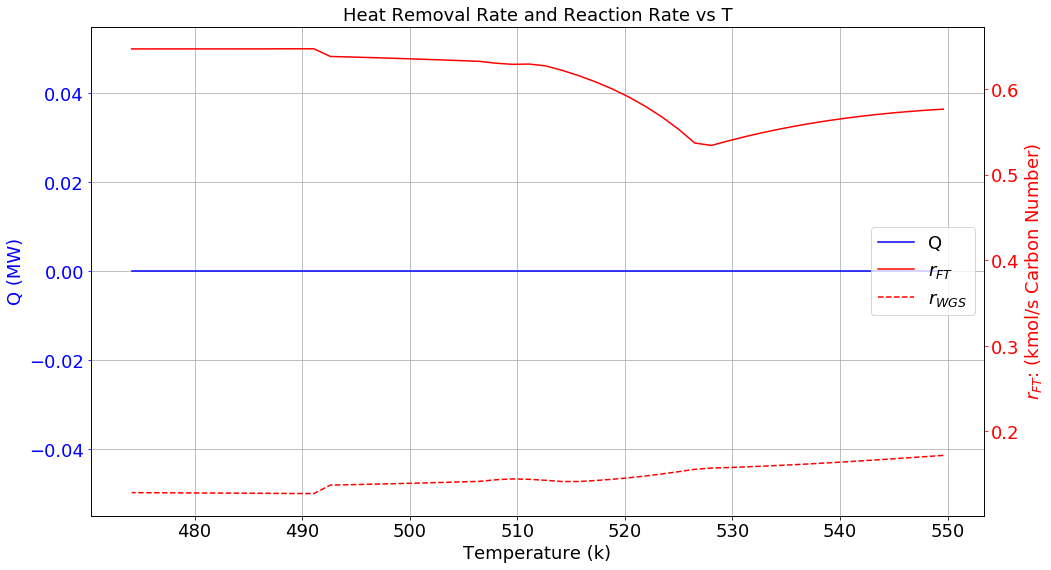

In [34]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['Q'], 'b-')
ax1.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['T'],rf_data['r_FT'], 'r')
line3 = ax2.plot(rf_data['T'],rf_data['r_WGS'], 'r--')
ax2.set_ylabel('$r_{FT}$: (kmol/s Carbon Number)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3,['Q','$r_{FT}$','$r_{WGS}$'],fontsize=18,loc=5)
ax1.set_title('Heat Removal Rate and Reaction Rate vs T',fontsize=18)
plt.show()

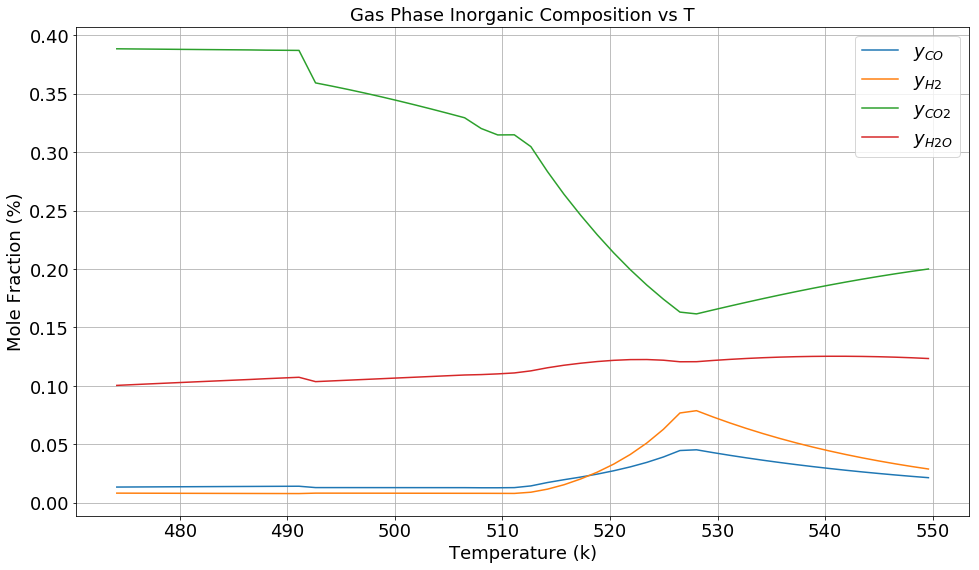

In [35]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['y_CO'])
ax.plot(rf_data['T'],rf_data['y_H2'])
ax.plot(rf_data['T'],rf_data['y_CO2'])
ax.plot(rf_data['T'],rf_data['y_H2O'])

ax.legend(['$y_{CO}$','$y_{H2}$','$y_{CO2}$','$y_{H2O}$'],fontsize=18)
ax.set_title('Gas Phase Inorganic Composition vs T',fontsize=18)

ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

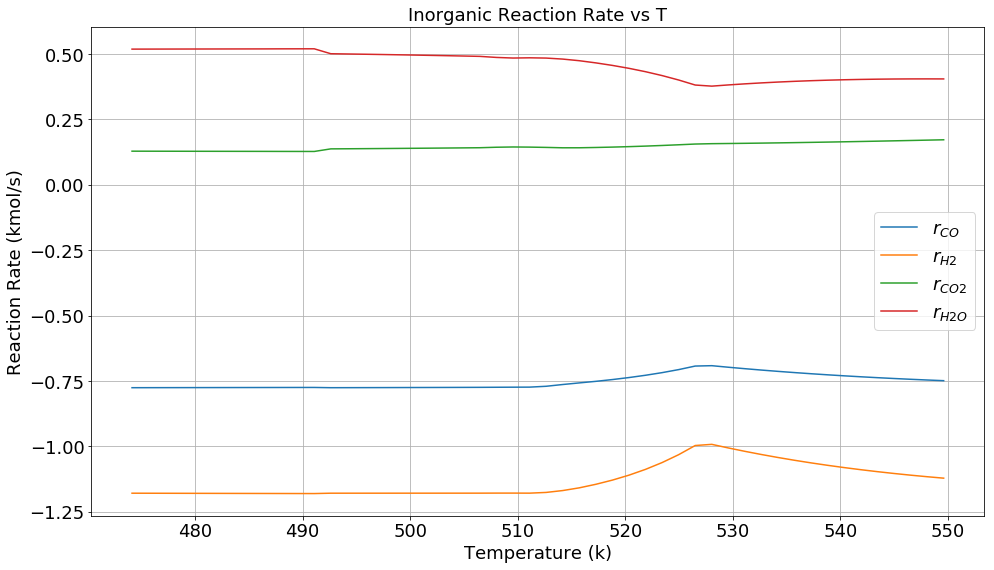

In [36]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['r']['CO'])
ax.plot(rf_data['T'],rf_data['r']['H2'])
ax.plot(rf_data['T'],rf_data['r']['CO2'])
ax.plot(rf_data['T'],rf_data['r']['H2O'])

ax.legend(['$r_{CO}$','$r_{H2}$','$r_{CO2}$','$r_{H2O}$'],fontsize=18)
ax.set_title('Inorganic Reaction Rate vs T',fontsize=18)

ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

In [39]:
reaction_data = trans_product_mole(rf_data['r'])['unscaled']
reaction_data_scaled = trans_product_mole(rf_data['r'])['scaled']

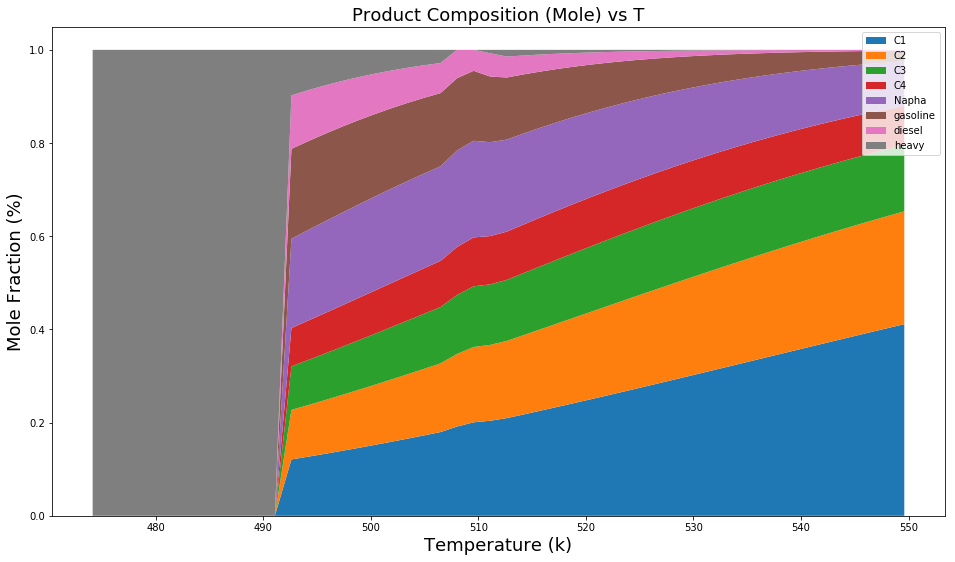

In [40]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data_scaled['c1'], reaction_data_scaled['c2'],reaction_data_scaled['c3'],reaction_data_scaled['c4'],\
            reaction_data_scaled['napha'],reaction_data_scaled['gasoline'],reaction_data_scaled['diesel'],reaction_data_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data['c1'], reaction_data['c2'],reaction_data['c3'],reaction_data['c4'],\
            reaction_data['napha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [ ]:
mass_data = {}
for i in m.COMP_ORG:
    mass_data[i] = np.array(rf_data['r'][i])*u.cal_MW(i)

In [ ]:
mass_reaction_data = u.trans_product(mass_data)
mass_reaction_scaled = u.trans_product_scaled(mass_data)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_scaled['c1'], mass_reaction_scaled['c2'],mass_reaction_scaled['c3'],mass_reaction_scaled['c4'],\
            mass_reaction_scaled['napha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_data['c1'], mass_reaction_data['c2'],mass_reaction_data['c3'],mass_reaction_data['c4'],\
            mass_reaction_data['napha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()